In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='icefire', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
class Neuron(eqx.Module):
    weight: jax.Array
    bias: jax.Array
    activation: callable

    def __init__(self, in_features, activation=jax.nn.relu, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
            key, _ = jax.random.split(key)
        w_key, b_key = jax.random.split(key)
        self.weight = jax.random.normal(w_key, (in_features,))
        self.bias = jax.random.normal(b_key, ())

        self.activation = activation

    def __call__(self, x):
        return self.activation(jnp.dot(self.weight, x) + self.bias)
    
    def importance(self):
        return jnp.linalg.norm(self.weight)


In [ ]:
def identity(x):
    return x


In [ ]:
class CustomMLP(eqx.Module):
    layers: list

    def __init__(self, input_size, hidden_sizes, output_size, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        keys = jax.random.split(key, len(hidden_sizes) + 1)
        act_key = jax.random.split(keys[-1], 1)[0]
        activation_list = [jax.nn.relu, jax.nn.sigmoid, jax.nn.tanh]
        layers = []
        in_features = input_size

        # Create hidden layers
        for i, out_features in enumerate(hidden_sizes):
            layer = [Neuron(in_features, activation_list[0], key=keys[i]) for _ in range(out_features)]
            layers.append(layer)
            in_features = out_features

        # Create output layer
        output_layer = [Neuron(in_features, activation=identity, key=keys[-1]) for _ in range(output_size)]
        layers.append(output_layer)

        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = jnp.array([neuron(x) for neuron in layer])
        return x[0]  # Since output layer is a single neuron

    def add_neuron(self, layer_index, activation=jax.nn.relu, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        in_features = self.layers[layer_index][0].weight.shape[0]
        new_neuron = Neuron(in_features, activation, key)
        self.layers[layer_index].append(new_neuron)

        # Adjust the next layer's weight matrix to include the new neuron
        if layer_index + 1 < len(self.layers):
            for i, next_neuron in enumerate(self.layers[layer_index + 1]):
                new_weight = jax.random.normal(key, (1,))
                updated_weights = jnp.append(next_neuron.weight, new_weight)
                self.layers[layer_index + 1][i] = eqx.tree_at(lambda n: n.weight, next_neuron, updated_weights)

    def remove_neuron(self, layer_index, neuron_index):
        if len(self.layers[layer_index]) > 0:
            del self.layers[layer_index][neuron_index]
        
        # Adjust the next layer's weight matrix to remove the corresponding weight
        if layer_index + 1 < len(self.layers):
            for i, next_neuron in enumerate(self.layers[layer_index + 1]):
                updated_weights = jnp.delete(next_neuron.weight, neuron_index)
                self.layers[layer_index + 1][i] = eqx.tree_at(lambda n: n.weight, next_neuron, updated_weights)
    
    def get_shape(self):
        return [len(layer) for layer in self.layers]

    def least_important_neuron(self):
        all_importances = []
        layer_sizes = []
        for layer in self.layers:
            importances = [n.importance() for n in layer]
            all_importances.append(jnp.array(importances).flatten())  # Flatten the importances
            layer_sizes.append(len(layer))

        all_importances = jnp.concatenate(all_importances)
        sorted_indices = jnp.argsort(all_importances)

        # Locate the layer and neuron index
        cum_neurons = jnp.cumsum(jnp.array(layer_sizes))
        for min_importance_index in sorted_indices:
            layer_index = jnp.searchsorted(cum_neurons, min_importance_index, side="right")
            neuron_index = min_importance_index - (cum_neurons[layer_index - 1] if layer_index > 0 else 0)
            if neuron_index != len(self.layers[layer_index]) - 1:  # If the neuron is not the last one of its layer
                return layer_index, neuron_index
        
        raise ValueError("All neurons are the last ones of their layers")

    def most_important_layer(self):
        # Calculate the total importance of each layer
        layer_importances = [jnp.sum(jnp.array([n.importance() for n in layer])) for layer in self.layers[:-1]]
        most_important_layer_index = jnp.argmax(jnp.array(layer_importances))  # Convert to Jax array

        return most_important_layer_index


In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))


In [ ]:

input_size = 3
hidden_sizes = [2, 3]  # Two hidden layers with 4 and 5 neurons respectively
output_size = 1
key = jax.random.PRNGKey(42)
mlp = CustomMLP(input_size, hidden_sizes, output_size, key)
opt = optax.sgd(learning_rate=1e-2)
opt_state = initialize_optimizer_state(mlp, opt)


2024-05-24 19:24:07.533744: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
mlp.get_shape()

[2, 3, 1]

In [ ]:
x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([1.0])

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = mlp(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
mlp = CustomMLP(input_size, hidden_sizes, output_size, key)

In [ ]:
activation_list = [jax.nn.relu, jax.nn.sigmoid, jax.nn.tanh]
jax.random.choice(key, jnp.arange(len(activation_list)))

Array(2, dtype=int32)

In [ ]:
activation_list = [jax.nn.relu, jax.nn.sigmoid, jax.nn.tanh]
num_epochs = 1000
add_node_every = 10
remove_node_every = 10
Loss_history = []
Node_history = []
Update_history = []
threshold = 1e-8

In [ ]:
len(mlp.layers[0])

2

In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    print(f"Epoch {epoch}, Prediction: {mlp(x)}, Loss: {loss}")

    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    Loss_history.append(loss)
    Node_history.append(n_neurons)


    # Dynamically add or remove neurons
    if (epoch + 1) % add_node_every == 0:
        if len(Update_history) == 0 or Update_history[-1][2] > loss or Update_history[-1][3] == "removed":
            # if no previous addition or last addition was rejected, add a neuron
            # if last addition was accepted, add a neuron
            add_key, act_key = jax.random.split(add_key)
            activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
            layer_idx = mlp.most_important_layer()
            mlp.add_neuron(layer_index=layer_idx, activation=activation, key=act_key)
            opt_state = initialize_optimizer_state(mlp, opt)

            Update_history.append((epoch, n_neurons, loss, activation.__name__, layer_idx))
            print(f"Added neuron to hidden layer {layer_idx+1} with activation {activation.__name__}")
            print(mlp.get_shape())
        
        elif Update_history[-1][2] < loss:
            # if last addition doesn't improve loss, remove the worst neuron

            layer_idx, neuron_idx = mlp.least_important_neuron()
            print(f"Removing neuron from hidden layer {layer_idx+1} at index {neuron_idx}")
            mlp.remove_neuron(layer_index=layer_idx, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            Update_history.append((epoch, n_neurons, loss, "removed", layer_idx))
            print(f"Rejecting last addition,\n Removed neuron from hidden layer {layer_idx+1} at index {neuron_idx}")
            print(mlp.get_shape())
        
    if loss < threshold:
        # if loss is below threshold, stop training
        print(f"Threshold reached, stopping training at epoch {epoch}")
        break
    


print("Final Prediction:", mlp(x))

Epoch 0, Prediction: -0.10243986546993256, Loss: 1.2654868364334106
Epoch 1, Prediction: -0.080391064286232, Loss: 1.2153736352920532
Epoch 2, Prediction: -0.05878324434161186, Loss: 1.167244791984558
Epoch 3, Prediction: -0.0376075804233551, Loss: 1.12102210521698
Epoch 4, Prediction: -0.016855429857969284, Loss: 1.076629400253296
Epoch 5, Prediction: 0.0034816786646842957, Loss: 1.0339950323104858
Epoch 6, Prediction: 0.02341204509139061, Loss: 0.9930487275123596
Epoch 7, Prediction: 0.0429438054561615, Loss: 0.9537240266799927
Epoch 8, Prediction: 0.062084928154945374, Loss: 0.9159564971923828
Epoch 9, Prediction: 0.08084322512149811, Loss: 0.8796846866607666
Added neuron to hidden layer 2 with activation sigmoid
[2, 4, 1]
Epoch 10, Prediction: -0.49277108907699585, Loss: 2.356466054916382
Epoch 11, Prediction: -0.451762318611145, Loss: 2.228365659713745
Epoch 12, Prediction: -0.4120034873485565, Loss: 2.1076138019561768
Epoch 13, Prediction: -0.37344861030578613, Loss: 1.9937539100

In [ ]:
Update_history

[(9, 6, Array(0.8796847, dtype=float32), 'sigmoid', Array(1, dtype=int32)),
 (19, 7, Array(1.4334427, dtype=float32), 'removed', Array(0, dtype=int32)),
 (29, 6, Array(0.83536696, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (39, 7, Array(0.33150783, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (49, 8, Array(0.25141242, dtype=float32), 'sigmoid', Array(1, dtype=int32)),
 (59, 9, Array(0.06945555, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (69, 10, Array(0.4186711, dtype=float32), 'removed', Array(1, dtype=int32)),
 (79, 9, Array(0.07566728, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (89, 10, Array(0.01370741, dtype=float32), 'relu', Array(1, dtype=int32)),
 (99, 11, Array(0.07210286, dtype=float32), 'removed', Array(1, dtype=int32)),
 (109, 10, Array(0.00553092, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (119, 11, Array(0.01030728, dtype=float32), 'removed', Array(1, dtype=int32)),
 (129, 10, Array(0.05293478, dtype=float32), 'sigmoid', Array(1, dtype=int32)),

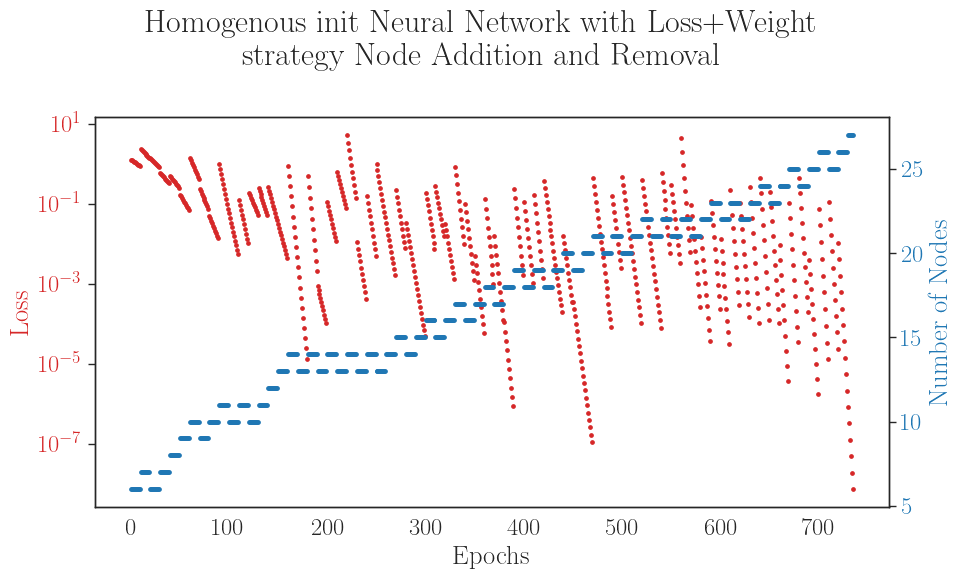

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,len(Loss_history)), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,len(Node_history)), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Homogenous init Neural Network with Loss+Weight\n strategy Node Addition and Removal")
fig.tight_layout()

In [ ]:
009, 06, 0.8796847, 'sigmoid', 1
019, 07, 1.4334427, 'removed', 0
029, 06, 0.83536696, 'tanh', 1
039, 07, 0.33150783, 'tanh', 1
049, 08, 0.25141242, 'sigmoid', 1
059, 09, 0.06945555, 'tanh', 1
069, 10, 0.4186711, 'removed', 1
079, 09, 0.07566728, 'tanh', 1
089, 10, 0.01370741, 'relu', 1
099, 11, 0.07210286, 'removed', 1
109, 10, 0.00553092, 'tanh', 1
119, 11, 0.01030728, 'removed', 1
129, 10, 0.05293478, 'sigmoid', 1
139, 11, 0.05114001, 'tanh', 1
149, 12, 0.03841683, 'relu', 1
159, 13, 0.00453647, 'relu', 1
169, 14, 0.00462849, 'removed', 1
179, 13, 1.3528298e-05, 'sigmoid', 1
189, 14, 0.00202855, 'removed', 1
199, 13, 0.00010543, 'sigmoid', 1
209, 14, 0.01143631, 'removed', 1
219, 13, 0.0771122, 'relu', 1
229, 14, 0.13672857, 'removed', 1
239, 13, 0.00042372, 'sigmoid', 1
249, 14, 0.00498769, 'removed', 1
259, 13, 0.04568998, 'relu', 1
269, 14, 0.00168244, 'relu', 1
279, 15, 0.007673, 'removed', 1
289, 14, 0.00150097, 'relu', 1
299, 15, 4.8165355e-05, 'sigmoid', 1
309, 16, 0.0073419, 'removed', 1
319, 15, 0.01553667, 'tanh', 1
329, 16, 0.00131737, 'relu', 1
339, 17, 0.00959903, 'removed', 1
349, 16, 0.00126446, 'sigmoid', 1
359, 17, 5.9533897e-05, 'tanh', 1
369, 18, 0.00100917, 'removed', 1
379, 17, 0.00012753, 'relu', 1
389, 18, 8.7258763e-07, 'sigmoid', 1
399, 19, 0.00165793, 'removed', 1
409, 18, 0.00102527, 'sigmoid', 1
419, 19, 0.00136476, 'removed', 1
429, 18, 0.01034744, 'tanh', 1
439, 19, 0.00019421, 'sigmoid', 1
449, 20, 0.00034602, 'removed', 1
459, 19, 7.764013e-06, 'relu', 1
469, 20, 1.10618714e-07, 'tanh', 1
479, 21, 0.00727019, 'removed', 1
489, 20, 8.21921e-05, 'sigmoid', 1
499, 21, 0.00241134, 'removed', 1
509, 20, 0.0089276, 'relu', 1
519, 21, 0.00010617, 'sigmoid', 1
529, 22, 0.0068238, 'removed', 1
539, 21, 7.859983e-05, 'relu', 1
549, 22, 0.00588542, 'removed', 1
559, 21, 0.00332775, 'relu', 1
569, 22, 0.00611589, 'removed', 1
579, 21, 0.00026195, 'sigmoid', 1
589, 22, 3.651445e-05, 'sigmoid', 1
599, 23, 0.00024107, 'removed', 1
609, 22, 3.1052066e-05, 'relu', 1
619, 23, 0.00029466, 'removed', 1
629, 22, 0.00015151, 'relu', 1
639, 23, 0.00010173, 'sigmoid', 1
649, 24, 0.00012774, 'removed', 1
659, 23, 0.00010355, 'sigmoid', 1
669, 24, 3.8035296e-06, 'sigmoid', 1
679, 25, 3.474281e-05, 'removed', 1
689, 24, 0.00020238, 'relu', 1
699, 25, 1.8044815e-06, 'relu', 1
709, 26, 1.29995215e-05, 'removed', 1
719, 25, 2.3921086e-05, 'tanh', 1
729, 26, 2.1269493e-06, 'relu', 1

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (2201454092.py, line 1)